# Deeperfont
*[Website](http://nbviewer.jupyter.org/github/terryspitz/ipython_notebooks/blob/master/deeperfont.ipynb)*

Deeperfont is a Neural Network attempt at the 'Font Problem' - how to capture the essence of a font in such a way as to generalise to unseen letters and to allow interpolation between different fonts.

Initial research suggested the use of [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) as best practise for both getting started and long-term research.  As output the network will generate a set of font outlines or [glyphs](https://en.wikipedia.org/wiki/Glyph).  The encoding of outputs has been considered in two ways: raw (x,y) coordinates, as expressed in the TTF font glyphs, or a conversion of these outlines to (angle, distance) pairs as in [Turtle graphics](https://en.wikipedia.org/wiki/Turtle_graphics) (best known for it's  use in [Logo](https://en.wikipedia.org/wiki/Logo_(programming_language).)

Considering the evaluation function we note that the exact sequence of points in the glyph can be varied while generating identical rendered output, for example a line segment can be split into a number of smaller colinear segments.  The network should be free to express its results in any equivalent way.  The evaluation function is therefore required to compare rendered output.  We build an evaluation function in pure Tensorflow using a [scanline algorithm](https://en.wikipedia.org/wiki/Scanline_rendering) to generate a tensor containing the x coordinates of the outline for a set of equi-spaced y line.  The predicted and true outlines are then compared by calculating the difference in visible pixels.

While the network will output the outline into the Y variable, the Y_true will store a rendered outline to be consumed directly by the evaluation function.

As input we provide the letter to render, in the form of a [one-hot](https://en.wikipedia.org/wiki/One-hot) vector.

See also:
* [MetaFont](https://en.wikipedia.org/wiki/Metafont)
* [Metaflop - interactive MetaFont](http://www.metaflop.com/modulator)
* [deepfont](https://erikbern.com/2016/01/21/analyzing-50k-fonts-using-deep-neural-networks.html)
* https://arxiv.org/abs/1507.03196
* https://pypi.python.org/pypi/FontTools


In [120]:
import numpy as np
import math
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageChops, ImageFont
from keras.models import Sequential
import keras.layers as layers
from keras import backend as K
import tensorflow as tf

In [131]:
def renderGlyph(gl, max_points_per_line, ygrid):
    '''
    Pure tensorflow function
    Input: 1D list of glyph outlines as (angle, distance) pairs 
    Output: matrix of sorted top x coords for each line per y coording
    '''
    angles = gl[::2]
    dists = gl[1::2]

    linexs = tf.cumsum(tf.abs(dists)*tf.cos(angles*math.pi))+1e-4
    x1s = linexs[:-1]
    x2s = linexs[1:]
    lineys = tf.cumsum(tf.abs(dists)*tf.sin(angles*math.pi))+1e-4
    y1s = lineys[:-1]
    y2s = lineys[1:]

    xx1s=tf.expand_dims(x1s,-1)
    xx2s=tf.expand_dims(x2s,-1)
    yy1s=tf.expand_dims(y1s,-1)
    yy2s=tf.expand_dims(y2s,-1)

    #interpolate the x coords for all lines at all y coord
    xxs = xx1s + (xx2s-xx1s)*(ygrid-yy1s)/(yy2s-yy1s)
    in_range = tf.logical_or(tf.logical_and(yy1s<ygrid, ygrid<=yy2s), tf.logical_and(yy2s<ygrid, ygrid<=yy1s))
    xxs = tf.cast(in_range, tf.float32) * xxs * tf.expand_dims(tf.sign(dists[1:]),-1)
    return tf.nn.top_k(tf.transpose(xxs),max_points_per_line).values

def drawGlyph(xxs, ygrid):
    '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
    size = 500
    im = Image.new('1', size=(size, size), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for xs, y in zip(xxs, ygrid):
        for x in xs:
            if x>0.0:
                draw.ellipse((x*size, (1.0-y)*size, x*size+3, (1.0-y)*size+3), fill=1)
    return im

In [132]:
def angleDist(p1, p2, hidden, unitsPerEm):
    """Given two point tuples return the angle scaled to [-1,1], and distance scaled similarly"""
    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    return math.atan2(dy,dx)/math.pi, math.sqrt(dx**2 + dy**2) * (-1 if hidden else 1) / unitsPerEm  #negative distance means hidden

def generateTrueOutput(ttx, letters, max_points_per_line, ygrid):
    """
    Read the actual points from all letters in the font into numpy array.
    Output is array of letters x points x 2 (angle in radians, distance).
    We use float according to https://github.com/fchollet/keras/issues/2218.
    """
    
    unitsPerEm = int(ttx.find('head/unitsPerEm').get('value'))
    numletters = len(letters)
    Y = np.zeros((numletters, len(ygrid),max_points_per_line), np.float32)
    for i, l in enumerate(letters):
        glyph = ttx.find(r".//TTGlyph[@name='"+l+"']")
        outline = []
        p=0 #point count across all contours (shapes)
        startp = (0,0)

        #ttx contours are areas within the letter, like the outside and inside of an O
        for contour in glyph.iterfind('contour'):
            pts = contour.iterfind('pt')
            xy = [(int(pt.get('x')), int(pt.get('y'))) for pt in pts] #should read the ttx 'on' attribute too for bezier control points
            #fill output matrix, start with hidden line to start position
            outline += angleDist(startp, xy[0], True, unitsPerEm)
            startp = xy[0]
            p+=2
            #then between points
            for n in range(len(xy)-1):
                outline += angleDist(xy[n],xy[n+1], False, unitsPerEm)
                p+=2
            #finally wrap last point to first in contour
            N=len(xy)-1
            outline += angleDist(xy[N],xy[0], False, unitsPerEm)
            p+=2
        print
        xxs = renderGlyph(np.array(outline, dtype=np.float32), max_points_per_line, ygrid)
        #print(xxs.eval())
        Y[i] = xxs.eval()
    return Y

def setupInputOutputRender(ttx, letters, outputdim):
    """
    Generate target output by rendering each glyph and reading X coords of the outline.
    Target Output is matrix of x coords of outline for each y coord
    We use float not int according to https://github.com/fchollet/keras/issues/2218.
    """
    numletters = len(letters)
    Y = np.zeros((numletters, outputdim*2), np.float32)
    for i, letter in enumerate(letters):
        im = Image.new('1', size=(cellsize, cellsize), color=(0)) 
        draw = ImageDraw.Draw(im) 
        fnt = ImageFont.truetype('deeper/Quicksand-Bold.otf', cellsize)
        draw.text((10,10), letter, font=fnt, fill=1)
        im = ImageChops.logical_xor(im,  ImageChops.offset(im, 1, 0))
        print(im.tobytes())
        Y[i] = np.fromstring(im.tobytes())
    
    return Y

def drawAllLetters(Y):
    """Draw numpy array interpreted as a letter per row and each row containing (angle, dist) pairs."""
    columns = 13
    rows = math.ceil(Y.shape[0]/columns)
    def drawPoints(im, points):
        #temporary image to use to xor each part with main image
        im2 = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
        draw = ImageDraw.Draw(im2) 
        draw.polygon(points, fill=1)
        im = ImageChops.logical_xor(im, im2)
        return im
    scale = cellsize * 0.8
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    for i in range(Y.shape[0]):
        y,x = divmod(i, columns)
        x *= cellsize
        y = (y+1)*cellsize-1
        points = []
        for j in range(0, Y.shape[1], 2):
            angle = Y[i][j]
            dist = Y[i][j+1]
            x2 = x+ abs(dist)*math.cos(angle*math.pi)*scale
            y2 = y- abs(dist)*math.sin(angle*math.pi)*scale
            if dist>0:
                points += (x2,y2)
            elif len(points)>2:
                im = drawPoints(im, points)
                points=[]
            x=x2
            y=y2
    if len(points)>2:
        im = drawPoints(im, points)
    return im

setup...


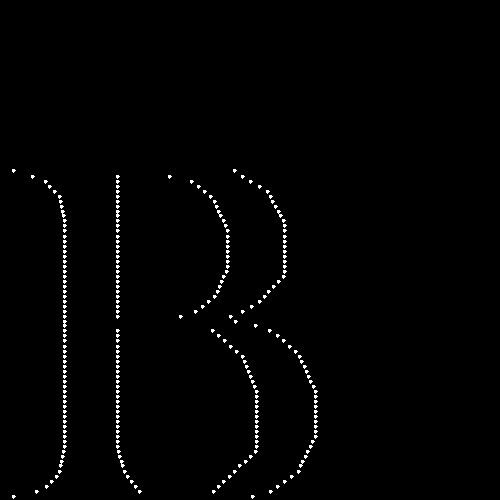

In [133]:
print('setup...')
letters = [chr(i) for i in range(ord('A'), ord('Z')+1)]
letters += [chr(i) for i in range(ord('a'), ord('z')+1)]
letters += ['zero','one','two','three','four','five','six','seven','eight','nine']
letters = ['A','B']
np.set_printoptions(precision=2)
ttx = ET.parse(r'deeper/BASKVILL.ttx') #read font data dumped from TrueType using fonttools
#outputdim = readFont(ttx, letters)
max_points_per_line = 10
ygrid = np.linspace(0.0, 1.0, 100, endpoint=False) #y coordinates to render on
X = np.identity(len(letters), dtype=float)  #input is 'one-hot' array, one per letter
with tf.Session() as sess:
    Y_true = generateTrueOutput(ttx, letters, max_points_per_line, ygrid)
    #print(Y_true)
    #drawAllLetters(Y)
    #xxs = renderGlyph(tf.constant(Y[1]), max_points_per_line, ygrid)
    im = drawGlyph(Y_true[1], ygrid)
im

In [134]:
def glyphDiffTF(y_true, y_pred):
    return tf.reduce_max(renderGlyph(y_true, max_points_per_line, ygrid), axis=0)#-tf.reduce_min(glyph(y_pred, axis=1)) 

print('compile model...')
model = Sequential()
model.add(layers.Dense(20, input_dim=X.shape[1]))
#model.add(Dense(600, activation='relu'))
#model.add(LSTM(4))#, return_sequences=True))
model.add(layers.Dense(30, name='outlines'))
model.add(layers.Lambda(lambda outline:renderGlyph(outline, max_points_per_line, ygrid), name='renderGlyph'))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

print('fit the model...')
model.fit(X, Y_true, epochs=500, batch_size=len(letters), verbose=1)

compile model...
fit the model...


ValueError: Error when checking target: expected renderGlyph to have shape (100, 30, 10) but got array with shape (2, 100, 10)

In [125]:
print('evaluate the model...')
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print('predict outlines...')
outlines_model = Model(inputs=model.input,
                                 outputs=model.get_layer('outlines').output)
newY = outlines_model.predict(X, verbose=1)

print("true vs pred:")
print(Y[0][:20])
print(newY[0][:20])
drawAllLetters(newY)

evaluate the model...


NameError: name 'Y' is not defined

In [ ]:
#now, what happens when we predict mixed letters?
newY = model.predict(np.random.random(X.shape), verbose=1)
drawAllLetters(newY)

In [ ]:
#what about interpolating between letters?  let's try gradually mixing A into B
#need array [[1, 0, ...], [1, 0.1, ...]]
A = X[0]
B = X[1]
steps=12
mix = np.array([A*(steps-i)/steps + i*B/steps for i in range(steps+1)])
#print(mix[:3])
newY = model.predict(mix, verbose=1)
drawAllLetters(newY)
#not very convincing :(, perhaps raw points rather than angle, dist pairs for the outline would be better
#also need to try interpolating A between two fonts